In [1]:
import h5py
import os

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from scipy.signal import wiener
from tqdm import tqdm

fe.set_log_level(50)


# ##########################
# step 0: relevant constants
DATA_FILE = "../data/Run08_G0_dt4.0_de1.0_ne5_velocity.nc"
length_ref = 0.1
B = 5
L = 20
r = 0.5

# #######################################
# step 1: read in and preprocess the data
ds = xr.open_dataset(DATA_FILE)

# first we get the locations of the observation points with respect to our grid
ds_zero = ds.isel(time=0)
ds_zero_missing = ds_zero.where(ds_zero.isnull(), drop=True)

x = ds_zero.coords["x"].to_numpy() / length_ref
y = ds_zero.coords["y"].to_numpy() / length_ref

x_missing = ds_zero_missing.coords["x"].to_numpy() / length_ref
y_missing = ds_zero_missing.coords["y"].to_numpy() / length_ref

# compute global `x` coordinates
x_displacement = np.min(x[x > np.max(x_missing)])
x_center_displacement = r - x_displacement
x_global_displacement = L / 2 + x_center_displacement
x_global = x + x_global_displacement

# compute global `y` coordinates
y_mid = y[len(y) // 2]
y_global = B / 2 + (y - y_mid)

# and create meshgrid according to our current setup
x_mg, y_mg = np.meshgrid(x_global, y_global, indexing="ij")

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
# then we average the data spatially
u_spatial_averaged = np.mean(ds.U, axis=(1, 2, 3))
v_spatial_averaged = np.mean(ds.V, axis=(1, 2, 3))

# start from where the flow is nearest to 0.
idx_start = np.argmin(np.abs(u_spatial_averaged.values - 0.))
idx_end = len(u_spatial_averaged.values)

u_depth_averaged = np.mean(ds.U, axis=-1)
v_depth_averaged = np.mean(ds.V, axis=-1)

u_depth_averaged = u_depth_averaged.isel(time=slice(idx_start, idx_end))
v_depth_averaged = v_depth_averaged.isel(time=slice(idx_start, idx_end))

u_depth_averaged["time"].dtype == np.datetime64
u_depth_averaged = u_depth_averaged.assign_coords(
    dict(time_rel=((u_depth_averaged["time"] 
                    - u_depth_averaged["time"][0]) * 1e-9).astype(float)))
v_depth_averaged = v_depth_averaged.assign_coords(
    dict(time_rel=((v_depth_averaged["time"] 
                    - v_depth_averaged["time"][0]) * 1e-9).astype(float)))
u_depth_averaged

<xarray.DataArray 'U' (time: 218, x: 64, y: 48)>
array([[[ 3.32461794e-04,  2.28321062e-04,  8.41260803e-05, ...,
         -1.01692155e-03, -1.01736529e-03, -9.70264850e-04],
        [ 3.21461574e-04,  2.24298969e-04,  1.09306077e-04, ...,
         -9.69385378e-04, -9.40876073e-04, -9.25488003e-04],
        [ 3.67069255e-04,  2.81094599e-04,  1.97430882e-04, ...,
         -8.99291344e-04, -8.80503867e-04, -8.63772164e-04],
        ...,
        [-6.03561978e-05, -5.32024491e-05, -4.94446984e-05, ...,
          1.52195909e-05,  1.64824203e-05,  6.20214198e-05],
        [-7.88615528e-05, -7.63504324e-05, -7.34907335e-05, ...,
          5.13749018e-06,  5.06688787e-06,  3.32368394e-05],
        [-8.18966817e-05, -6.64736089e-05, -6.00989855e-05, ...,
          1.39096679e-05,  1.16041639e-05,  2.41744227e-05]],

       [[ 1.19976296e-03,  1.14448214e-03,  1.09443390e-03, ...,
          1.43159248e-04,  1.01443262e-04,  4.87466137e-05],
        [ 1.24073902e-03,  1.17356282e-03,  1.14517830e-03, ...,
          1.32469842e-04,  7.17302014e-05,  6.16075158e-05],
        [ 1.26315679e-03,  1.21119768e-03,  1.19033824e-03, ...,
          7.33961876e-05,  4.34683686e-05,  4.19072347e-05],
...
        [ 5.18643738e-03,  5.16462866e-03,  5.12519878e-03, ...,
          4.75528122e-03,  4.62379673e-03,  4.56663371e-03],
        [ 5.32332358e-03,  5.21578101e-03,  5.13171637e-03, ...,
          4.83586620e-03,  4.69327275e-03,  4.60661829e-03],
        [ 5.30132870e-03,  5.27395645e-03,  5.15396207e-03, ...,
          4.86745546e-03,  4.78135690e-03,  4.72308819e-03]],

       [[ 5.25905682e-03,  5.29201378e-03,  5.38426547e-03, ...,
          4.83100722e-03,  4.68103117e-03,  4.56165768e-03],
        [ 5.23810580e-03,  5.24690822e-03,  5.32682273e-03, ...,
          4.84821459e-03,  4.65627420e-03,  4.54393960e-03],
        [ 5.11630452e-03,  5.16752014e-03,  5.21405663e-03, ...,
          4.84401385e-03,  4.66261532e-03,  4.57529936e-03],
        ...,
        [ 4.73105304e-03,  4.70733605e-03,  4.63190288e-03, ...,
          4.43145405e-03,  4.35508301e-03,  4.35580333e-03],
        [ 4.77076593e-03,  4.74940241e-03,  4.68431614e-03, ...,
          4.44503883e-03,  4.41397486e-03,  4.43688257e-03],
        [ 4.78290171e-03,  4.76356556e-03,  4.74462687e-03, ...,
          4.43408266e-03,  4.45973088e-03,  4.42980520e-03]]])
Coordinates:
  * time      (time) datetime64[ns] 2016-07-14T23:43:12.464000 ... 2016-07-14...
  * x         (x) float32 0.01056 0.01584 0.02112 ... 0.3326 0.3379 0.3432
  * y         (y) float32 0.01056 0.01584 0.02112 ... 0.2482 0.2534 0.2587
    time_rel  (time) float64 0.0 4.0 8.0 12.0 16.0 ... 864.0 868.0 872.0 876.0

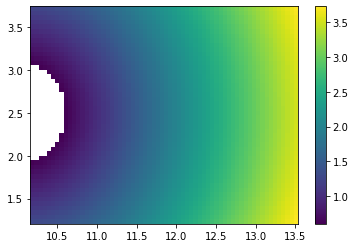

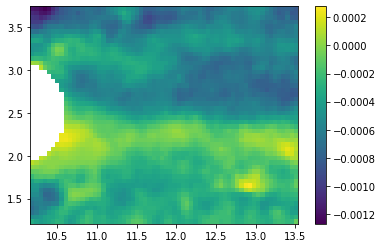

0.003205394745324609 0.03083272618032106
(2938,) (2938,) (218, 2938)
(2938, 2)


In [3]:
ud = u_depth_averaged.to_numpy()
vd = v_depth_averaged.to_numpy()
nt_obs = ud.shape[0]

c = np.sqrt((x_mg - 10)**2 + (y_mg - 2.5)**2)
mask = (c <= 0.6)

c_filtered = np.copy(c)
c_filtered[mask] = np.nan

# filter the data as needed
ud_filtered = np.copy(ud[120, :, :])
ud_filtered[mask] = np.nan

im = plt.pcolormesh(x_mg, y_mg, c_filtered)
plt.colorbar(im)
plt.show()

im = plt.pcolormesh(x_mg, y_mg, ud_filtered)
plt.colorbar(im)
plt.show()

# and check that things are sensible
assert ud.shape == vd.shape
assert ud[0, :, :].shape == x_mg.shape
assert vd[0, :, :].shape == y_mg.shape

filter_width = 3
nrows, ncols = vd[0, :, :].shape

sigma_u_est = np.zeros((nrows, ncols))
sigma_v_est = np.zeros((nrows, ncols))

for i in range(nrows):
    for j in range(ncols):
        ud_filtered = wiener(ud[:, i, j], filter_width)
        vd_filtered = wiener(vd[:, i, j], filter_width)
        
        sigma_u_est[i, j] = np.std(ud[:, i, j] - ud_filtered)
        sigma_v_est[i, j] = np.std(vd[:, i, j] - vd_filtered)
        
# check that the min/max variances are sound
print(np.amin(sigma_u_est[~np.isnan(sigma_u_est)] / 0.01), 
      np.amax(sigma_u_est[~np.isnan(sigma_u_est)] / 0.01))

# at this stage the data is ready to be assimilated into the model
# mask things as needed
x_obs = np.vstack((x_mg[~mask], y_mg[~mask])).T
t_obs = u_depth_averaged.coords["time_rel"].to_numpy()
u_obs = ud[:, ~mask]
v_obs = vd[:, ~mask]

print(x_mg[~mask].shape,  y_mg[~mask].shape, ud[:, ~mask].shape)
print(x_obs.shape)

# check that any NaNs are absent
assert np.any(np.isnan(u_obs)) == False
assert np.any(np.isnan(v_obs)) == False

[ 0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8  5.2
  5.6  6.   6.4  6.8  7.2  7.6  8.   8.4  8.8  9.2  9.6 10.  10.4 10.8
 11.2 11.6 12.  12.4 12.8 13.2 13.6 14.  14.4 14.8 15.2 15.6 16.  16.4
 16.8 17.2 17.6 18.  18.4 18.8 19.2 19.6 20.  20.4 20.8 21.2 21.6 22.
 22.4 22.8 23.2 23.6 24.  24.4 24.8 25.2 25.6 26.  26.4 26.8 27.2 27.6
 28.  28.4 28.8 29.2 29.6 30.  30.4 30.8 31.2 31.6 32.  32.4 32.8 33.2
 33.6 34.  34.4 34.8 35.2 35.6 36.  36.4 36.8 37.2 37.6 38.  38.4 38.8
 39.2 39.6 40.  40.4 40.8 41.2 41.6 42.  42.4 42.8 43.2 43.6 44.  44.4
 44.8 45.2 45.6 46.  46.4 46.8 47.2 47.6 48.  48.4 48.8 49.2 49.6 50.
 50.4 50.8 51.2 51.6 52.  52.4 52.8 53.2 53.6 54.  54.4 54.8 55.2 55.6
 56.  56.4 56.8 57.2 57.6 58.4 58.8 59.2 59.6 60.  60.4 60.8 61.2 61.6
 62.  62.4 63.2 63.6 64.  64.4 64.8 65.2 65.6 66.  66.4 66.8 67.2 67.6
 68.  68.4 68.8 69.2 69.6 70.  70.4 70.8 71.2 71.6 72.  72.4 72.8 73.2
 73.6 74.  74.4 74.8 75.2 75.6 76.  76.4 76.8 77.2 77.6 78.  78.4 78.8
 79.2 79

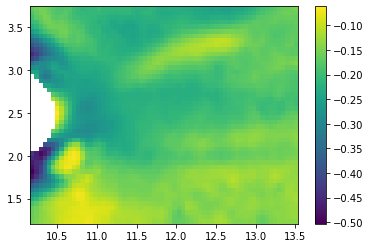

In [42]:
t_ref = 10.
u_ref = 0.01

idx_fail = np.argwhere(t_obs / t_ref == 19.6).flatten()
print(t_obs / t_ref, idx_fail / len(t_obs))

im = plt.pcolormesh(x_mg, y_mg, ud[idx_fail[0], :, :] / 0.01)
plt.colorbar(im)
plt.show()

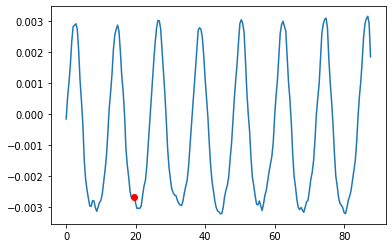

In [44]:
xi = 16
yi = 24

plt.plot(t_obs / t_ref, ud[:, xi, yi])
plt.plot(t_obs[idx_fail[0]] / t_ref, ud[idx_fail[0], xi, yi], "o", color="red")
plt.show()